In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [22]:
# functions for the different allocation strategies

# function for the standard one-choice allocation
def one_choice(m):
    # randomly selects a bin from the m bins
    return random.randint(0, m - 1)

# function for the two-choice allocation
def two_choice(m, loads):
    # randomly selects two bins from the m bins
    choices = random.sample(range(m), 2)
    # returns the bin with the least load; random if tied
    return choices[0] if loads[choices[0]] <= loads[choices[1]] else choices[1]

# function for the (1 + β)-choice allocation
def one_plus_beta_choice(m, loads, beta=0.5):
    # with probability β, use one-choice
    if random.random() < beta:
        return one_choice(m)
    # with probability 1 - β, use two-choice
    else:
        return two_choice(m, loads)
    
# function for the partial information choice
def partial_information_choice(m, loads):
    # selects two candidate bins at random
    candidates = random.sample(range(m), 2)
    # first question: is each candidate's load above the median?
    median_load = np.median(loads)
    load_above_median = [loads[c] > median_load for c in candidates]

    # if one is above and the other not, choose the one below
    if load_above_median[0] != load_above_median[1]:
        return candidates[0] if not load_above_median[0] else candidates[1]

    # if both are below the median, ask if they are in the 75% most loaded
    top_75 = np.percentile(loads, 75)
    in_top_75 = [loads[c] > top_75 for c in candidates]
    
    # return the one not in the top 75% if there's a difference
    if in_top_75[0] != in_top_75[1]:
        return candidates[0] if not in_top_75[0] else candidates[1]
    # otherwise pick one at random
    return random.choice(candidates)

# function to run the allocation simulation with the specified strategy
def allocation_simulation(m, n, strategy, beta=0.5, batch_size=1, partial_info=False):
    # initializes loads for each bin
    loads = np.zeros(m, dtype=int)
    # iterates over all balls, in batches if specified
    for i in range(0, n, batch_size):
        batch_end = min(i + batch_size, n)
        for _ in range(i, batch_end):
            # select bin based on the allocation strategy
            if strategy == 'one_choice':
                bin_choice = one_choice(m)
            elif strategy == 'two_choice':
                bin_choice = two_choice(m, loads)
            elif strategy == 'one_plus_beta_choice':
                bin_choice = one_plus_beta_choice(m, loads, beta)
            elif partial_info:
                bin_choice = partial_information_choice(m, loads)
            
            # increments load for the chosen bin
            loads[bin_choice] += 1
    
    # calculates the maximum load and the gap
    max_load = np.max(loads)
    gap = max_load - n / m
    return gap, loads



In [23]:
# function to perform multiple runs and compute average gap and variance
def run_experiments(m, n, strategy, beta=0.5, batch_size=1, partial_info=False, T=10):
    gaps = []
    # repeats experiment T times
    for _ in range(T):
        gap, _ = allocation_simulation(m, n, strategy, beta, batch_size, partial_info)
        gaps.append(gap)
    
    # calculates average gap and standard deviation
    avg_gap = np.mean(gaps)
    std_dev_gap = np.std(gaps)
    return avg_gap, std_dev_gap

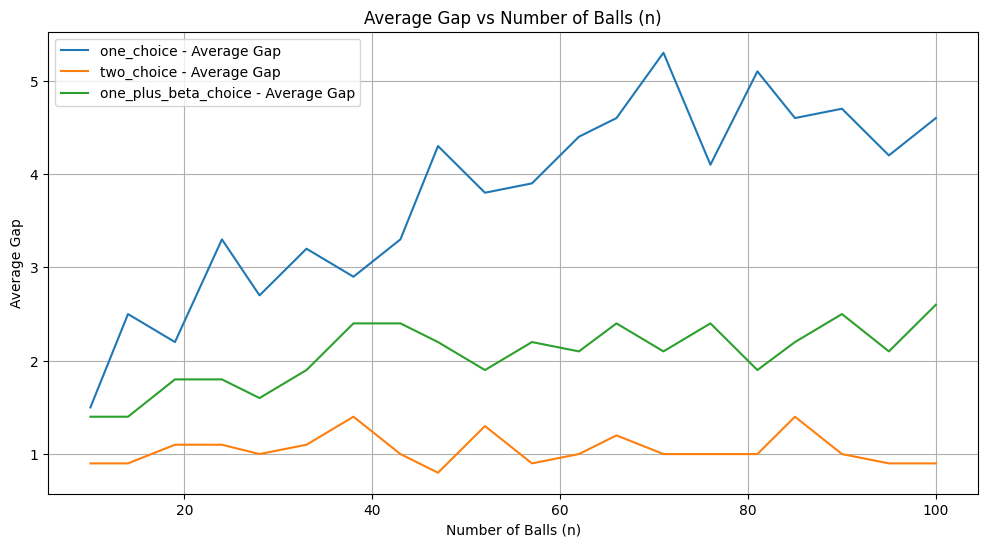

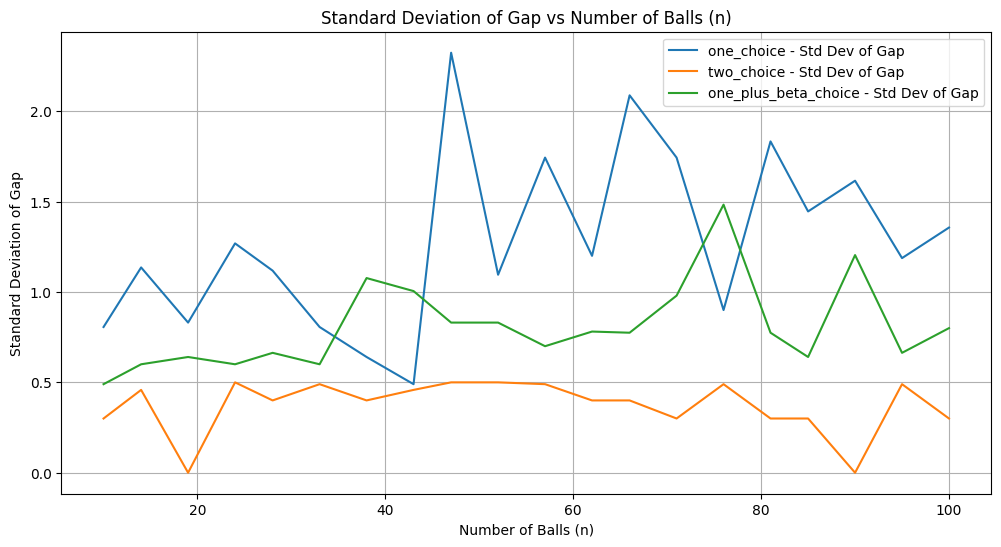

In [ ]:
# setting parameters for the scenarios
m = 10
n_values = np.linspace(m, m ** 2, num=20, dtype=int)
beta = 
T = 10

strategies = ['one_choice', 'two_choice', 'one_plus_beta_choice']

# Data collection for plotting
results = {strategy: {'n': [], 'avg_gap': [], 'std_dev_gap': []} for strategy in strategies}

# Run experiments and collect data for each strategy
for n in n_values:
    for strategy in strategies:
        avg_gap, std_dev_gap = run_experiments(m, n, strategy, beta, T)
        results[strategy]['n'].append(n)
        results[strategy]['avg_gap'].append(avg_gap)
        results[strategy]['std_dev_gap'].append(std_dev_gap)

# Plotting
plt.figure(figsize=(12, 6))
for strategy in strategies:
    plt.plot(results[strategy]['n'], results[strategy]['avg_gap'], label=f"{strategy} - Average Gap")
plt.title("Average Gap vs Number of Balls (n)")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for strategy in strategies:
    plt.plot(results[strategy]['n'], results[strategy]['std_dev_gap'], label=f"{strategy} - Std Dev of Gap")
plt.title("Standard Deviation of Gap vs Number of Balls (n)")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Standard Deviation of Gap")
plt.legend()
plt.grid(True)
plt.show()

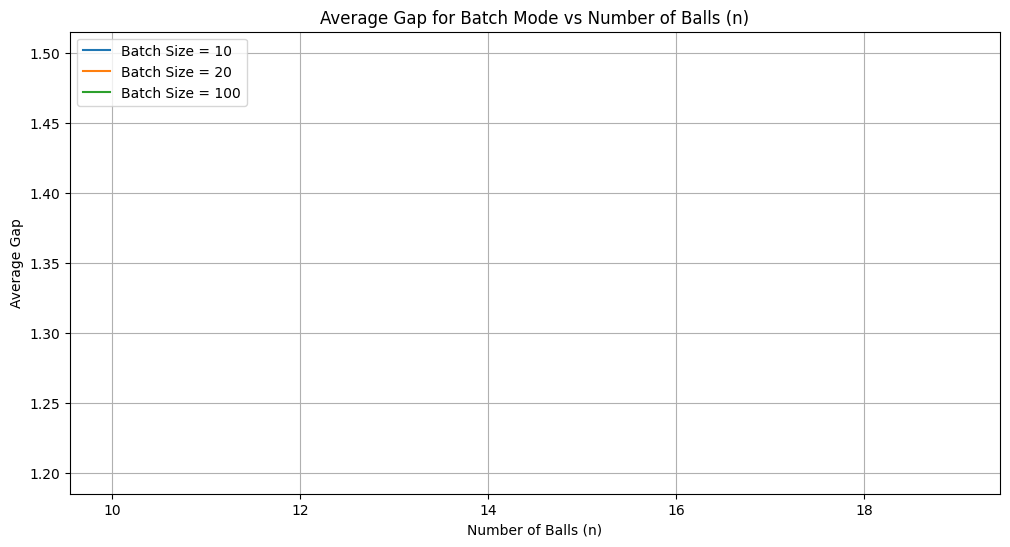

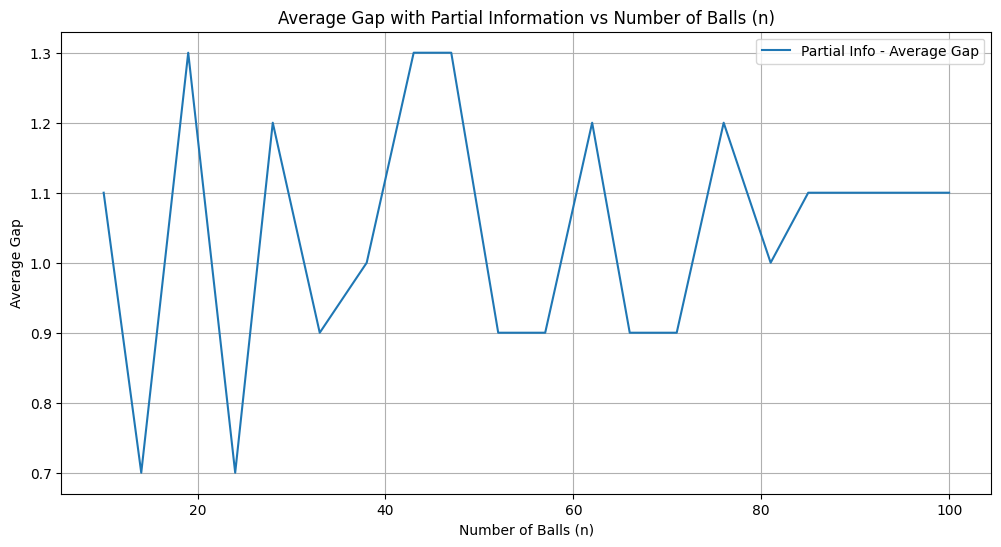

In [25]:
# Batch and Partial Information Experiments
batch_sizes = [m, 2 * m, 10 * m]
partial_info_results = {'batch': {'n': [], 'avg_gap': [], 'std_dev_gap': []},
                        'partial_info': {'n': [], 'avg_gap': [], 'std_dev_gap': []}}

# Batch experiments
for batch_size in batch_sizes:
    for n in n_values:
        avg_gap, std_dev_gap = run_experiments(m, n, 'one_plus_beta_choice', beta=0.5, batch_size=batch_size, T=10)
        partial_info_results['batch']['n'].append(n)
        partial_info_results['batch']['avg_gap'].append(avg_gap)
        partial_info_results['batch']['std_dev_gap'].append(std_dev_gap)

# Partial information experiments
for n in n_values:
    avg_gap, std_dev_gap = run_experiments(m, n, 'two_choice', partial_info=True, T=10)
    partial_info_results['partial_info']['n'].append(n)
    partial_info_results['partial_info']['avg_gap'].append(avg_gap)
    partial_info_results['partial_info']['std_dev_gap'].append(std_dev_gap)

# Plot Batch results
plt.figure(figsize=(12, 6))
for batch_size, n_list, avg_gap_list in zip(batch_sizes, partial_info_results['batch']['n'], partial_info_results['batch']['avg_gap']):
    plt.plot(n_list, avg_gap_list, label=f"Batch Size = {batch_size}")
plt.title("Average Gap for Batch Mode vs Number of Balls (n)")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()


# Plot Partial Information results
plt.figure(figsize=(12, 6))
plt.plot(partial_info_results['partial_info']['n'], partial_info_results['partial_info']['avg_gap'], label="Partial Info - Average Gap")
plt.title("Average Gap with Partial Information vs Number of Balls (n)")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()

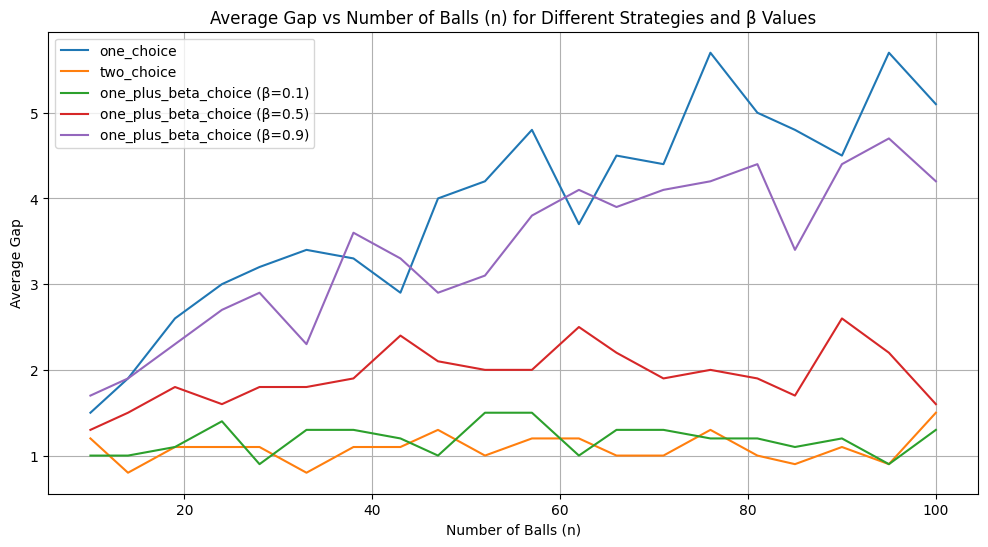

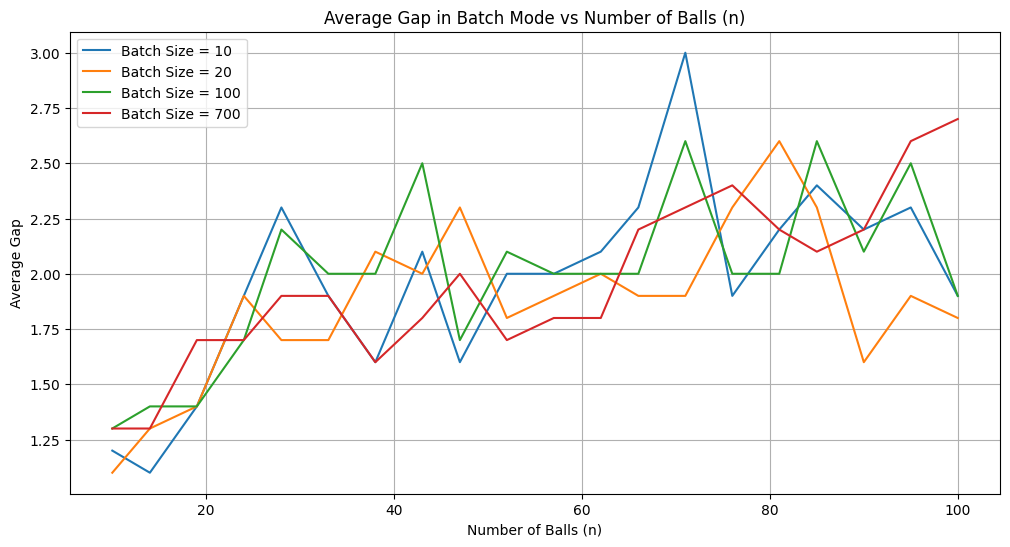

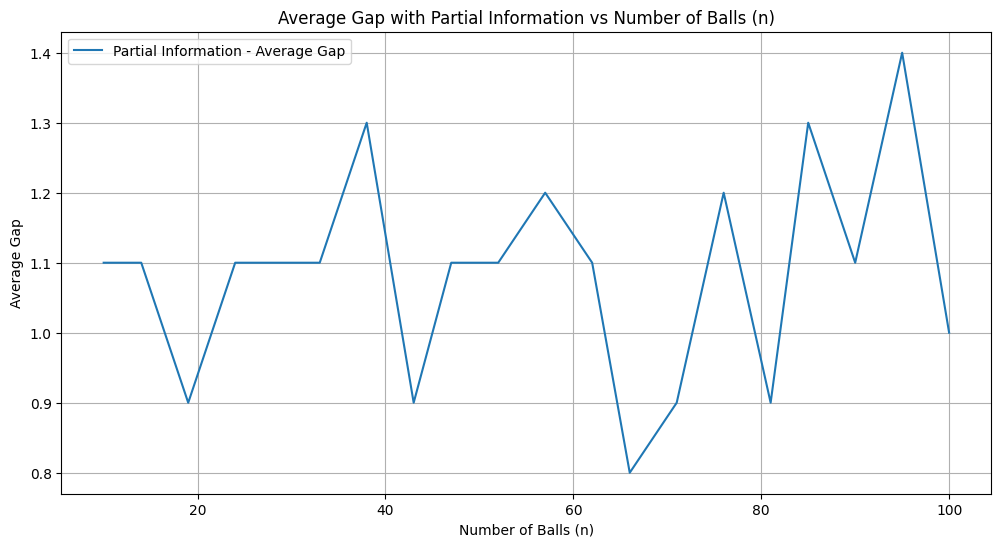

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


def one_choice(m):
    return random.randint(0, m - 1)

def two_choice(m, loads):
    choices = random.sample(range(m), 2)
    return choices[0] if loads[choices[0]] <= loads[choices[1]] else choices[1]

def one_plus_beta_choice(m, loads, beta=0.5):
    if random.random() < beta:
        return one_choice(m)
    else:
        return two_choice(m, loads)

def partial_information_choice(m, loads):
    candidates = random.sample(range(m), 2)
    median_load = np.median(loads)
    load_above_median = [loads[c] > median_load for c in candidates]
    if load_above_median[0] != load_above_median[1]:
        return candidates[0] if not load_above_median[0] else candidates[1]
    top_75 = np.percentile(loads, 75)
    in_top_75 = [loads[c] > top_75 for c in candidates]
    if in_top_75[0] != in_top_75[1]:
        return candidates[0] if not in_top_75[0] else candidates[1]
    return random.choice(candidates)

# simulation function
def allocation_simulation(m, n, strategy, beta=0.5, batch_size=1, partial_info=False):
    loads = np.zeros(m, dtype=int)
    for i in range(0, n, batch_size):
        batch_end = min(i + batch_size, n)
        for _ in range(i, batch_end):
            if strategy == 'one_choice':
                bin_choice = one_choice(m)
            elif strategy == 'two_choice':
                bin_choice = two_choice(m, loads)
            elif strategy == 'one_plus_beta_choice':
                bin_choice = one_plus_beta_choice(m, loads, beta)
            elif partial_info:
                bin_choice = partial_information_choice(m, loads)
            loads[bin_choice] += 1
    max_load = np.max(loads)
    gap = max_load - n / m
    return gap, loads

# run experiments
def run_experiments(m, n, strategy, beta=0.5, batch_size=1, partial_info=False, T=10):
    gaps = []
    for _ in range(T):
        gap, _ = allocation_simulation(m, n, strategy, beta, batch_size, partial_info)
        gaps.append(gap)
    avg_gap = np.mean(gaps)
    std_dev_gap = np.std(gaps)
    return avg_gap, std_dev_gap

# Parameters for scenarios
m = 10
n_values = np.linspace(m, m ** 2, num=20, dtype=int)  # Expanded intermediate n values
betas = [0.1, 0.5, 0.9]  # Different beta values
T = 10
strategies = ['one_choice', 'two_choice', 'one_plus_beta_choice']

# Data collection for different strategies and betas
results = {strategy: {beta: {'n': [], 'avg_gap': [], 'std_dev_gap': []} for beta in ([0] if strategy != 'one_plus_beta_choice' else betas)} for strategy in strategies}

for n in n_values:
    for strategy in strategies:
        if strategy == 'one_plus_beta_choice':
            for beta in betas:
                avg_gap, std_dev_gap = run_experiments(m, n, strategy, beta=beta, T=T)
                results[strategy][beta]['n'].append(n)
                results[strategy][beta]['avg_gap'].append(avg_gap)
                results[strategy][beta]['std_dev_gap'].append(std_dev_gap)
        else:
            avg_gap, std_dev_gap = run_experiments(m, n, strategy, T=T)
            results[strategy][0]['n'].append(n)
            results[strategy][0]['avg_gap'].append(avg_gap)
            results[strategy][0]['std_dev_gap'].append(std_dev_gap)

# Plotting for different strategies and betas
plt.figure(figsize=(12, 6))
for strategy in strategies:
    for beta, data in results[strategy].items():
        label = f"{strategy} (β={beta})" if strategy == 'one_plus_beta_choice' else strategy
        plt.plot(data['n'], data['avg_gap'], label=label)
plt.title("Average Gap vs Number of Balls (n) for Different Strategies and β Values")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()

# Batch Mode Experiments
batch_sizes = [m, 2 * m, 10 * m, 70 * m]
batch_results = {batch_size: {'n': [], 'avg_gap': [], 'std_dev_gap': []} for batch_size in batch_sizes}

for batch_size in batch_sizes:
    for n in n_values:
        avg_gap, std_dev_gap = run_experiments(m, n, 'one_plus_beta_choice', beta=0.5, batch_size=batch_size, T=T)
        batch_results[batch_size]['n'].append(n)
        batch_results[batch_size]['avg_gap'].append(avg_gap)
        batch_results[batch_size]['std_dev_gap'].append(std_dev_gap)

# Plot Batch results
plt.figure(figsize=(12, 6))
for batch_size, data in batch_results.items():
    plt.plot(data['n'], data['avg_gap'], label=f"Batch Size = {batch_size}")
plt.title("Average Gap in Batch Mode vs Number of Balls (n)")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()

# Partial Information Experiments
partial_info_results = {'n': [], 'avg_gap': [], 'std_dev_gap': []}
for n in n_values:
    avg_gap, std_dev_gap = run_experiments(m, n, 'two_choice', partial_info=True, T=T)
    partial_info_results['n'].append(n)
    partial_info_results['avg_gap'].append(avg_gap)
    partial_info_results['std_dev_gap'].append(std_dev_gap)

# Plot Partial Information results
plt.figure(figsize=(12, 6))
plt.plot(partial_info_results['n'], partial_info_results['avg_gap'], label="Partial Information - Average Gap")
plt.title("Average Gap with Partial Information vs Number of Balls (n)")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()


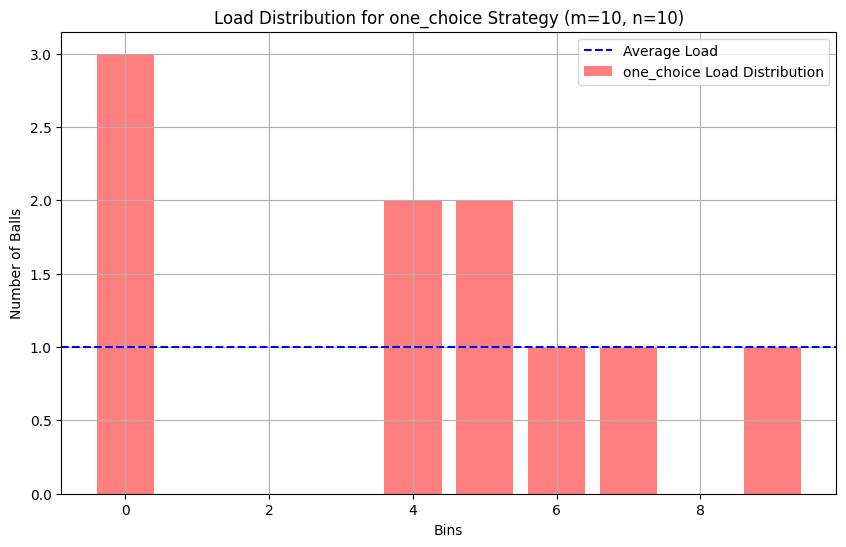

Max load: 3, Average load: 1.0, Gap: 2.0


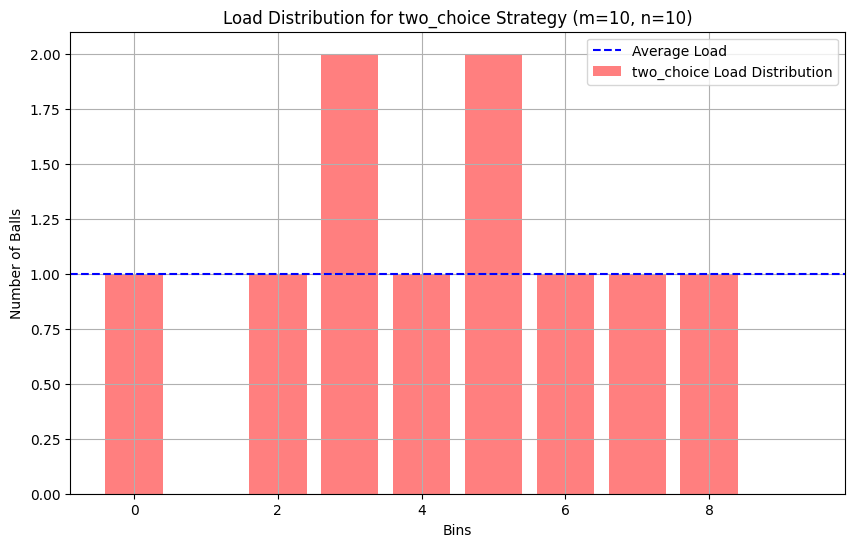

Max load: 2, Average load: 1.0, Gap: 1.0


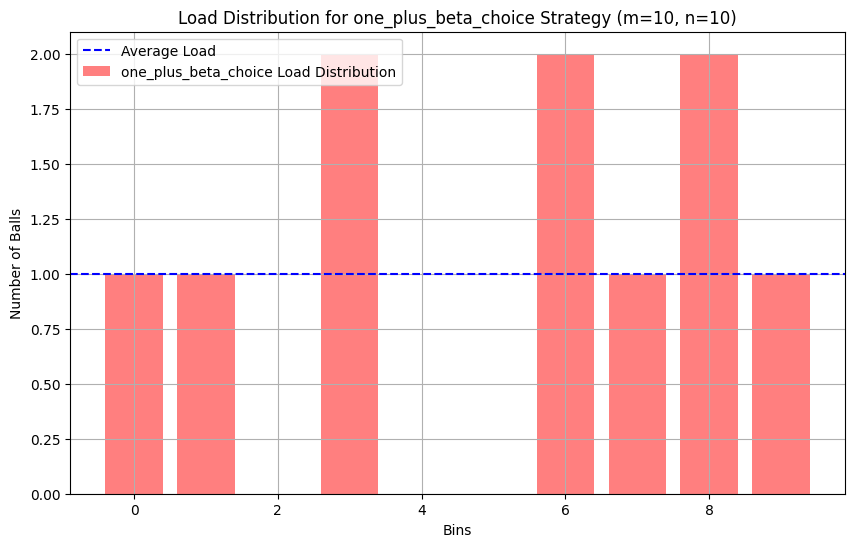

Max load: 2, Average load: 1.0, Gap: 1.0


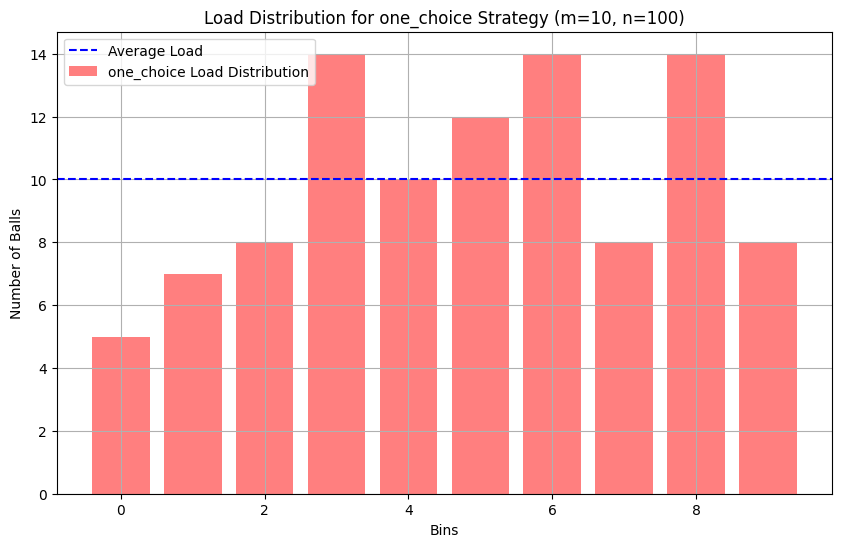

Max load: 14, Average load: 10.0, Gap: 4.0


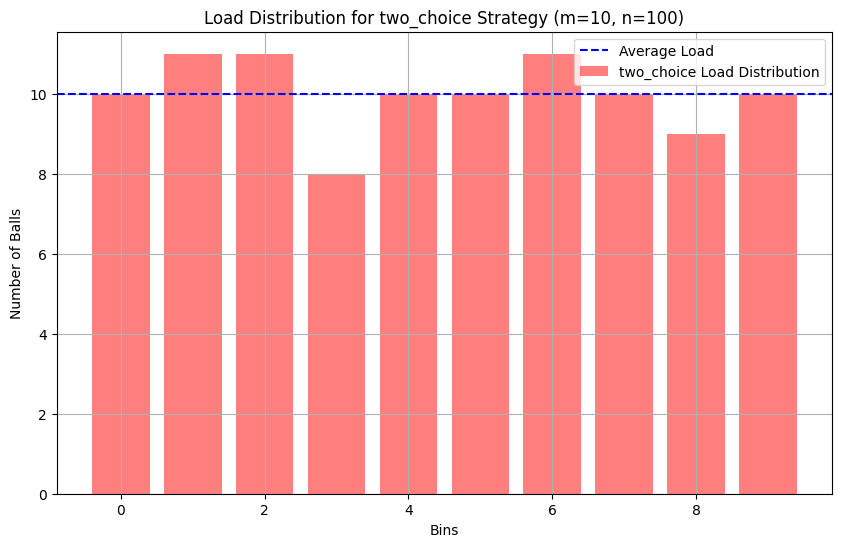

Max load: 11, Average load: 10.0, Gap: 1.0


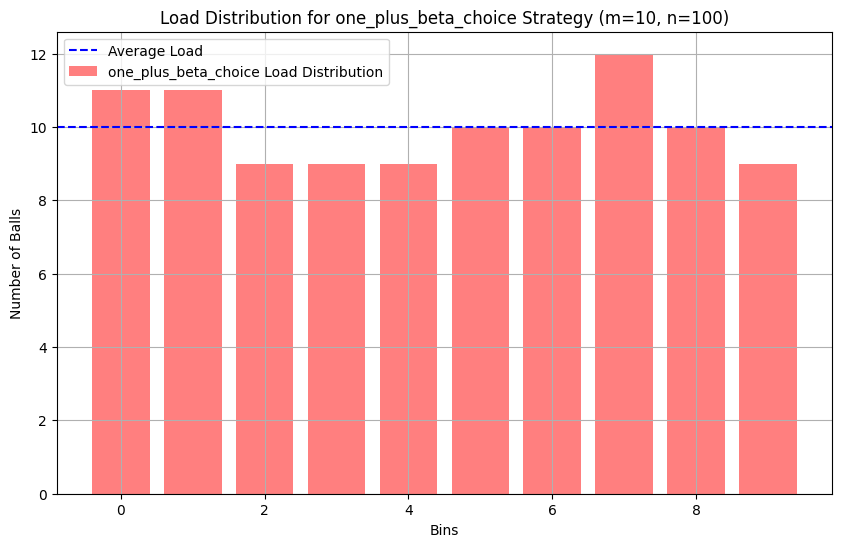

Max load: 12, Average load: 10.0, Gap: 2.0


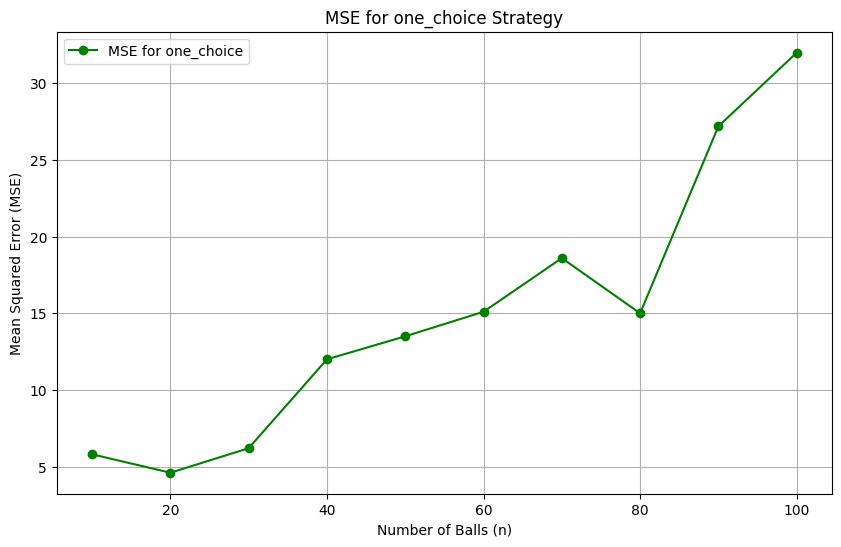

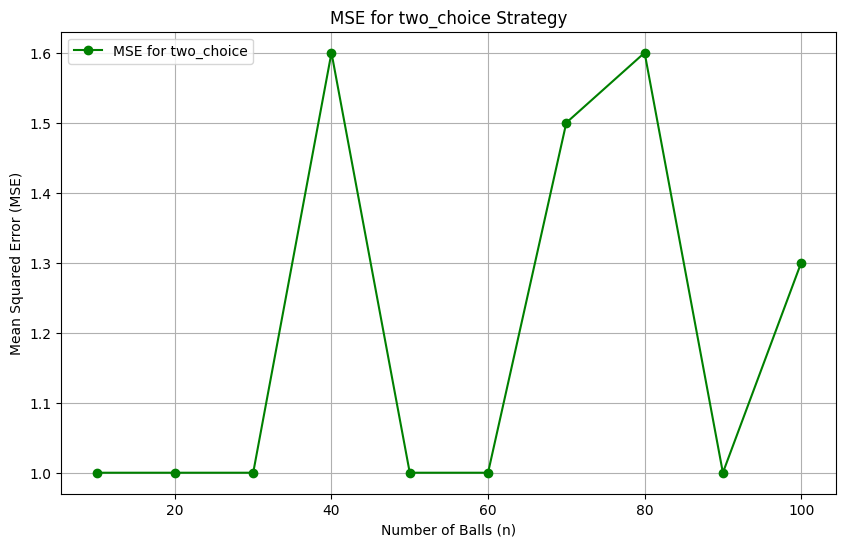

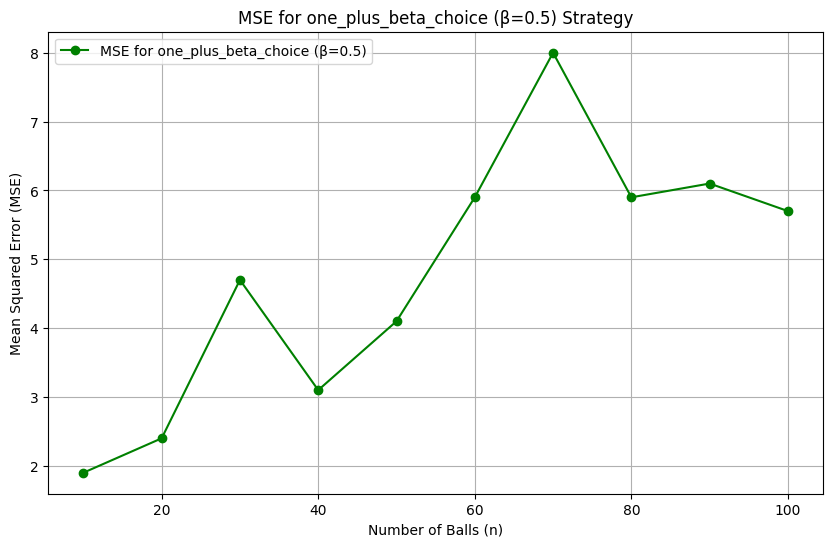

In [26]:
# all in one, but not done
import numpy as np
import random
import matplotlib.pyplot as plt

# One-choice allocation function
def one_choice(m):
    return random.randint(0, m - 1)

# Two-choice allocation function
def two_choice(m, loads):
    choices = random.sample(range(m), 2)
    return choices[0] if loads[choices[0]] <= loads[choices[1]] else choices[1]

# (1 + β)-choice allocation function
def one_plus_beta_choice(m, loads, beta=0.5):
    if random.random() < beta:
        return one_choice(m)
    else:
        return two_choice(m, loads)

# Function to run the allocation simulation
def allocation_simulation(m, n, strategy, beta=0.5):
    loads = np.zeros(m, dtype=int)
    
    for _ in range(n):
        if strategy == 'one_choice':
            bin_choice = one_choice(m)
        elif strategy == 'two_choice':
            bin_choice = two_choice(m, loads)
        elif strategy == 'one_plus_beta_choice':
            bin_choice = one_plus_beta_choice(m, loads, beta)
        
        loads[bin_choice] += 1

    max_load = np.max(loads)
    gap = max_load - n / m
    return gap, loads

# Function to show plot of load distribution
def show_load_plot(m, n, strategy, beta=0.5):
    gap, loads = allocation_simulation(m, n, strategy, beta)
    avg_load = n / m
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(m), loads, color='red', alpha=0.5, label=f'{strategy} Load Distribution')
    plt.axhline(avg_load, color='blue', linestyle='--', label='Average Load')
    plt.title(f'Load Distribution for {strategy} Strategy (m={m}, n={n})')
    plt.xlabel('Bins')
    plt.ylabel('Number of Balls')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Max load: {np.max(loads)}, Average load: {avg_load}, Gap: {gap}")

# Experiment with light-load scenario
m = 10
n = 10
show_load_plot(m, n, 'one_choice')
show_load_plot(m, n, 'two_choice')
show_load_plot(m, n, 'one_plus_beta_choice', beta=0.5)

# Experiment with heavy-load scenario
n = m**2
show_load_plot(m, n, 'one_choice')
show_load_plot(m, n, 'two_choice')
show_load_plot(m, n, 'one_plus_beta_choice', beta=0.5)

# Function to compute MSE for each strategy over multiple runs
def compute_mse(m, n_values, strategy, beta=0.5, runs=10):
    mse_values = []
    for n in n_values:
        gaps = []
        for _ in range(runs):
            gap, _ = allocation_simulation(m, n, strategy, beta)
            gaps.append(gap)
        mse = np.mean(np.square(gaps))
        mse_values.append(mse)
    return mse_values

# Function to plot MSE values
def plot_mse(m, n_values, mse_values, strategy):
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, mse_values, label=f'MSE for {strategy}', color='green', marker='o')
    plt.title(f'MSE for {strategy} Strategy')
    plt.xlabel('Number of Balls (n)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters for MSE calculation
n_values = range(m, m * m + 1, m)  # from m to m^2 in steps of m

# Compute and plot MSE for each strategy
mse_one_choice = compute_mse(m, n_values, 'one_choice')
mse_two_choice = compute_mse(m, n_values, 'two_choice')
mse_one_plus_beta_choice = compute_mse(m, n_values, 'one_plus_beta_choice', beta=0.5)

plot_mse(m, n_values, mse_one_choice, 'one_choice')
plot_mse(m, n_values, mse_two_choice, 'two_choice')
plot_mse(m, n_values, mse_one_plus_beta_choice, 'one_plus_beta_choice (β=0.5)')
